## Analyzing NYC High School Data

New York City published data on student SAT scores by high school, along with additional demographic datasets.  

New York City has a large immigrant population, so comparing demographic factors to SAT scores is a good way to determine whether the SAT is a fair test.  

In this project, we will perform analysis to learn more about the relationships between demographic factors and SAT scores.

## Reading Data

In [33]:
import os
os.environ['PROJ_LIB'] = 'C:\\Users\\nluth\\Anaconda3\\library\\share'

import pandas as pd
import numpy
import re
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv'
]

data = {}

for f in data_files:
    d = pd.read_csv('schools/{0}'.format(f))
    data[f.replace('.csv', '')] = d

## Reading Surveys

In [34]:
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey['DBN'] = survey['dbn']

survey_fields = [
    'DBN', 
    'rr_s', 
    'rr_t', 
    'rr_p', 
    'N_s', 
    'N_t', 
    'N_p', 
    'saf_p_11', 
    'com_p_11', 
    'eng_p_11', 
    'aca_p_11', 
    'saf_t_11', 
    'com_t_11', 
    'eng_t_11', 
    'aca_t_11', 
    'saf_s_11', 
    'com_s_11', 
    'eng_s_11', 
    'aca_s_11', 
    'saf_tot_11', 
    'com_tot_11', 
    'eng_tot_11', 
    'aca_tot_11',
]
survey = survey[survey_fields]
data['survey'] = survey

C:\Users\nluth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


## Adding Columns

In [35]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return '0' + string_representation
    
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

## Converting Column Datatype

In [36]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lat = coords[0].split(',')[0].replace('(', '')
    return lat

def find_lon(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lon = coords[0].split(',')[1].replace(')', '').strip()
    return lon

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

## Condensing Datasets

In [37]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

class_size = class_size.groupby('DBN').agg(numpy.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size

data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

## Converting AP Score Datatype

In [38]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')

## Combining Datasets

In [39]:
combined = data['sat_results']

combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for m in to_merge:
    combined = combined.merge(data[m], on='DBN', how='inner')

combined = combined.fillna(combined.mean())

combined = combined.fillna(0)

## Adding School District Column

In [40]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined['school_dist'] = combined['DBN'].apply(get_first_two_chars)

## Calculating Correlations

In [41]:
correlations = combined.corr()
correlations = correlations['sat_score']
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Visualizing Survey Results

In [42]:
# Remove DBN because it is not a unique identifier
survey_fields.remove('DBN')

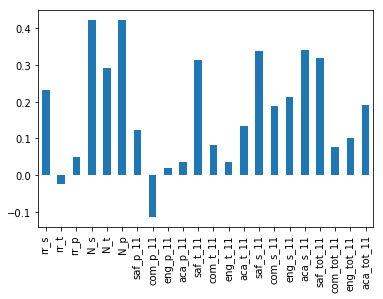

In [43]:
combined.corr()['sat_score'][survey_fields].plot.bar()

There are relatively high correlations between N_s, N_t, N_p, and sat_score.  This intuitively makes sense because we would expect the number of survey responses to correlate with total enrollment.

What we find more interesting is that the student response rate, rr_s, correlates with sat_score.  A plausible reason this might be the case is that students who are more likely to fill out the survey may also be more engageed in school, thereby performing better academically.

Another observation is that student and teacher perceptions of safety, saf_t_11 and saf_s_11, also correlate with sat_score.  This also makes sense because it is hard to teach and learn in an unsafe environment.

The last notable observation is the correlation between sat_score and aca_s_11, which indicates how students perceive academic standards.  While this correlation is relatively high, the same observation is not true for how teachers and parents perceive academic standards.

## Data Exploration: Safety

Previously, we noted that student and teacher safety correlated with SAT scores.  Let's dig into this these relationships.

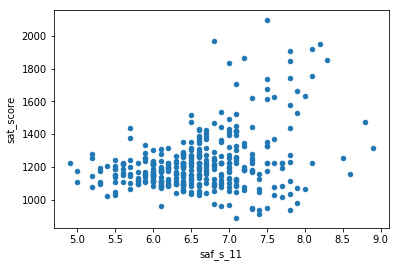

In [44]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

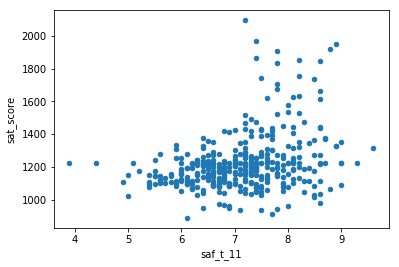

In [45]:
combined.plot.scatter(x='saf_t_11', y='sat_score')

There is a somewhat positive correlation between student and teacher safety perceptions and SAT scores.  One notable difference is that teachers tend to view safety more favorably than students.

Let's visualize how safety scores differ by school district.

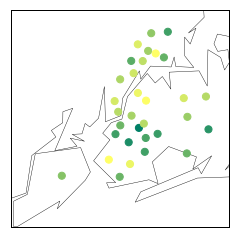

In [46]:
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='black', linewidth=0.4)
m.drawrivers(color='aqua', linewidth=0.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')

plt.show()

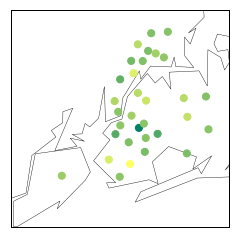

In [47]:
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='black', linewidth=0.4)
m.drawrivers(color='aqua', linewidth=0.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts['saf_t_11'], cmap='summer')

plt.show()

It looks like Upper Manhattan and parts of Queens tend to have higher safety scores, whereas Brooklyn and parts of the Bronx have lower safety scores.

## Data Exploration: Racial Disparity

Now let's investigate the relationship between race and SAT scores.

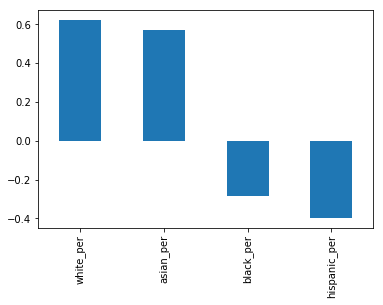

In [48]:
race_per = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()['sat_score'][race_per].plot.bar()

Based on the above chart, schools with a higher percentage of White and Asian students perform better on the SAT.  On the other hand, schools with a higher percentage of Black and Hispanic students tend to perform worse.

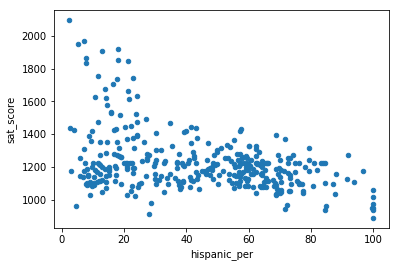

In [49]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

There is a clear negative correlation between percentage of students that are Hispanic and SAT score.

In [50]:
hispanic_schools = combined[combined['hispanic_per'] > 95]
print(hispanic_schools['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


A quick Google search reveals that the schools listed above are geared toward recent immigrants to the United States.  Given that these schools have a large population of students who are learning English and that the SAT is conducted in English, it makes sense these schools have lower SAT scores.

In [51]:
non_hispanic_schools = combined[combined['hispanic_per'] < 10]
non_hispanic_schools = non_hispanic_schools[non_hispanic_schools['sat_score'] > 1800]
print(non_hispanic_schools['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above tend to be specialized science and technology schools that receive extra funding and only admit students who pass an entrance exam.  This might explain why their students tend to perform well on the SAT.

## Data Exploration: Gender

It's clear that there is a disparity between race and SAT scores.  Let's see if this disparity persists for different genders.

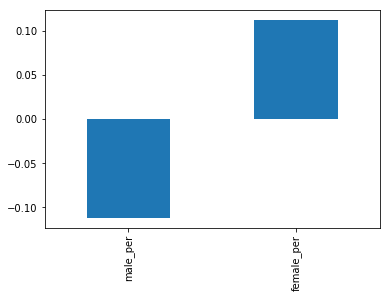

In [52]:
genders = ['male_per', 'female_per']

combined.corr()['sat_score'][genders].plot.bar()

While neither relationship is strong, it appears that schools with a greater percentage of female students perform better on the SAT.

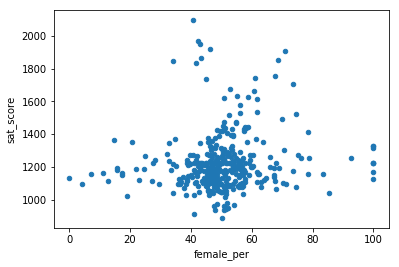

In [53]:
combined.plot.scatter(x='female_per', y='sat_score')

Based on the scatterplot, there does not seem to be any correlation between SAT scores and percentage of school that is female.  However, there is a cluster of schools that is majority female and scored highly on the SAT.

In [54]:
female_high_sat = combined[combined['female_per'] > 60]
female_high_sat = female_high_sat[female_high_sat['sat_score'] > 1700]
print(female_high_sat['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools that are predominantly female and score well on the SAT are selective liberal arts schools with high academic standards.

## Data Exploration: AP Test Takers

Finally, let's explore the relationship between SAT scores and students that took at least one AP exam.  We suspect that these students will tend to perform better on the SAT given that AP classes are considered advanced.

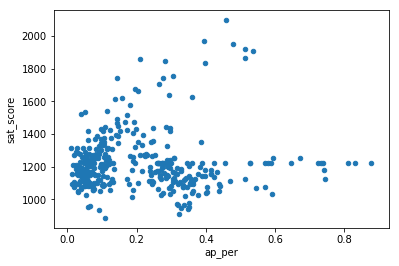

In [55]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

There appears to be a weak relationship between the percentage of students in a school who take the AP exam and SAT scores.